Lambda domain: 1.0, Beta KL: 0.02
Epoch 1, Total Loss: 233.9400, Recon: 232.5344, KL: 69.2064, Domain: 0.0215, Domain Acc: 0.53
Epoch 2, Total Loss: 122.5862, Recon: 120.9707, KL: 79.6903, Domain: 0.0216, Domain Acc: 0.52
Epoch 3, Total Loss: 79.8168, Recon: 78.3184, KL: 73.8571, Domain: 0.0213, Domain Acc: 0.55
Epoch 4, Total Loss: 69.0594, Recon: 67.6321, KL: 70.3114, Domain: 0.0210, Domain Acc: 0.57
Epoch 5, Total Loss: 65.2502, Recon: 63.8870, KL: 67.1156, Domain: 0.0209, Domain Acc: 0.58
Epoch 6, Total Loss: 63.3359, Recon: 62.0009, KL: 65.7159, Domain: 0.0207, Domain Acc: 0.60
Epoch 7, Total Loss: 62.1669, Recon: 60.8627, KL: 64.1895, Domain: 0.0204, Domain Acc: 0.61
Epoch 8, Total Loss: 61.4613, Recon: 60.1722, KL: 63.4469, Domain: 0.0202, Domain Acc: 0.65
Epoch 9, Total Loss: 59.6751, Recon: 58.3740, KL: 64.0564, Domain: 0.0199, Domain Acc: 0.66
Epoch 10, Total Loss: 58.7360, Recon: 57.4281, KL: 64.4111, Domain: 0.0197, Domain Acc: 0.67
Epoch 11, Total Loss: 57.5053, Recon: 56.

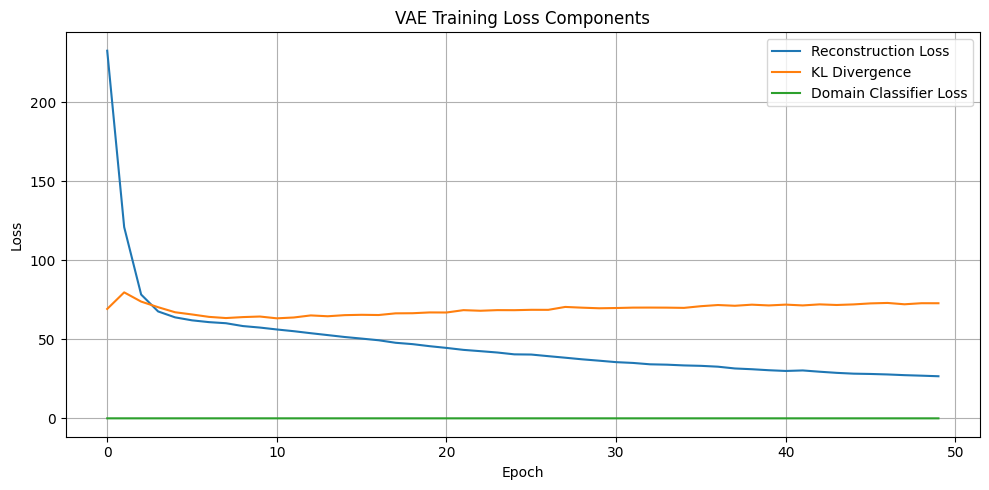

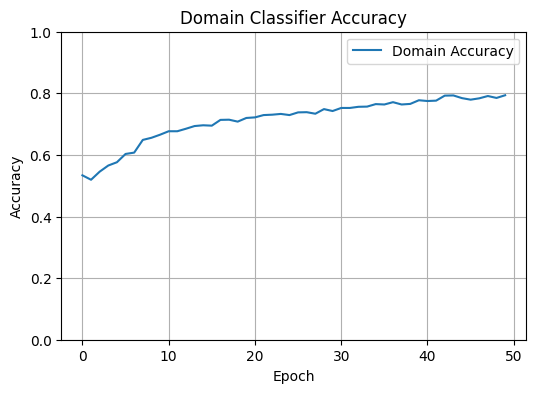

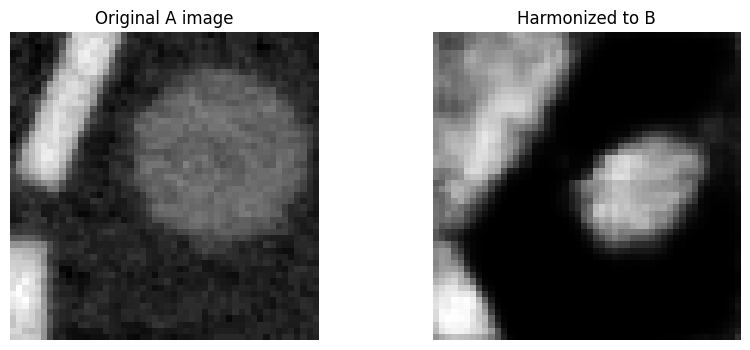

In [15]:
# %% [markdown]
# # 🔄 Domain Classifier VAE-Based Harmonization of Algorithm A → B Images
# This notebook trains a Conditional VAE with Domain Classifier to encourage separation of A and B in latent space.

# %% 
# ✅ Imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# %% 
# ✅ Load datasets
A = np.load("../../data/augmented_images_algoA.npy")
B = np.load("../../data/augmented_images_algoB.npy")

# Combine and create labels
X = np.concatenate([A, B], axis=0)  # shape (N, 50, 50)
y = np.concatenate([np.zeros(len(A)), np.ones(len(B))])  # 0 = A, 1 = B

# Reshape for PyTorch
X = X[:, None, :, :]  # shape (N, 1, 50, 50)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# %% 
# ✅ Define Conditional VAE + Domain Classifier
class CVAE(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.fc_mu = nn.Linear(64 * 12 * 12, latent_dim)
        self.fc_logvar = nn.Linear(64 * 12 * 12, latent_dim)

        self.decoder_fc = nn.Linear(latent_dim + 1, 64 * 12 * 12)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1), nn.Sigmoid(),
            nn.Upsample(size=(50, 50), mode='bilinear', align_corners=False)
        )
        
        # Domain classifier
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.ReLU(),
            nn.Linear(64, 1), nn.Sigmoid()
        )

    def encode(self, x, label):
        label = label.view(-1, 1, 1, 1).expand(-1, 1, x.size(2), x.size(3))
        x_cond = torch.cat([x, label], dim=1)
        h = self.encoder(x_cond).view(x.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, label):
        z = torch.cat([z, label.unsqueeze(1)], dim=1)
        h = self.decoder_fc(z).view(-1, 64, 12, 12)
        return self.decoder(h)

    def forward(self, x, label):
        mu, logvar = self.encode(x, label)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, label)
        domain_pred = self.classifier(mu)
        return recon, mu, logvar, domain_pred

# %% 


# %% 
# ✅ Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

lambda_domain = 1.0  # weight for domain loss
beta_kl = 0.02         # weight for KL divergence → prevents KL collapse
epochs = 50

print(f"Lambda domain: {lambda_domain}, Beta KL: {beta_kl}")

# Before loop
recon_losses = []
kl_losses = []
domain_losses = []
domain_accs = []  # NEW: track domain accuracy per epoch

# Training loop
for epoch in range(epochs):
    if epoch > 10:
        lambda_domain *= 1.05
    model.train()
    total_loss = 0
    total_recon = 0
    total_kl = 0
    total_domain = 0
    total_acc = 0  # NEW: for domain accuracy

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        recon, mu, logvar, domain_pred = model(xb, yb)

        recon_loss = F.mse_loss(recon, xb, reduction='sum')
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        
        # Domain classifier loss
        domain_labels = yb.view(-1, 1)  # (batch,1)
        domain_loss = F.binary_cross_entropy(domain_pred, domain_labels)

        # Total loss with beta_kl
        loss = recon_loss + beta_kl * kl + lambda_domain * domain_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate losses
        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl.item()
        total_domain += domain_loss.item()

        # Compute domain accuracy (per batch)
        with torch.no_grad():
            domain_pred_label = (domain_pred > 0.5).float()
            acc = (domain_pred_label == domain_labels).float().mean().item()
            total_acc += acc  # accumulate

    # Per epoch averages
    recon_losses.append(total_recon / len(train_loader.dataset))
    kl_losses.append(total_kl / len(train_loader.dataset))
    domain_losses.append(total_domain / len(train_loader.dataset))
    avg_acc = total_acc / len(train_loader)
    domain_accs.append(avg_acc)

    # Print
    print(f"Epoch {epoch+1}, Total Loss: {total_loss / len(train_loader.dataset):.4f}, Recon: {recon_losses[-1]:.4f}, KL: {kl_losses[-1]:.4f}, Domain: {domain_losses[-1]:.4f}, Domain Acc: {avg_acc:.2f}")

# %% 
# ✅ Plot Losses
plt.figure(figsize=(10, 5))
plt.plot(recon_losses, label='Reconstruction Loss')
plt.plot(kl_losses, label='KL Divergence')
plt.plot(domain_losses, label='Domain Classifier Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss Components')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# %% 
# ✅ Inference: Harmonize A → B
model.eval()
sample_idx = np.random.randint(0, len(A))
sample = torch.tensor(A[sample_idx:sample_idx+1], dtype=torch.float32).to(device)
sample = sample.unsqueeze(1)  # (1, 1, 50, 50)
label_A = torch.tensor([0.0], device=device)
label_B = torch.tensor([1.0], device=device)

with torch.no_grad():
    mu, logvar = model.encode(sample, label_A)
    z = model.reparameterize(mu, logvar)
    harmonized = model.decode(z, label_B).squeeze().cpu().numpy()

# ✅ Plot Domain Accuracy
plt.figure(figsize=(6,4))
plt.plot(domain_accs, label='Domain Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Domain Classifier Accuracy')
plt.ylim(0,1)
plt.grid(True)
plt.legend()
plt.show()


# %% 
# ✅ Visualize
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample.squeeze().cpu().numpy(), cmap='gray')
plt.title('Original A image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(harmonized, cmap='gray')
plt.title('Harmonized to B')
plt.axis('off')
plt.show()

# %% 
# ✅ Save model
torch.save(model.state_dict(), "cvae_harmonization_with_domain.pth")


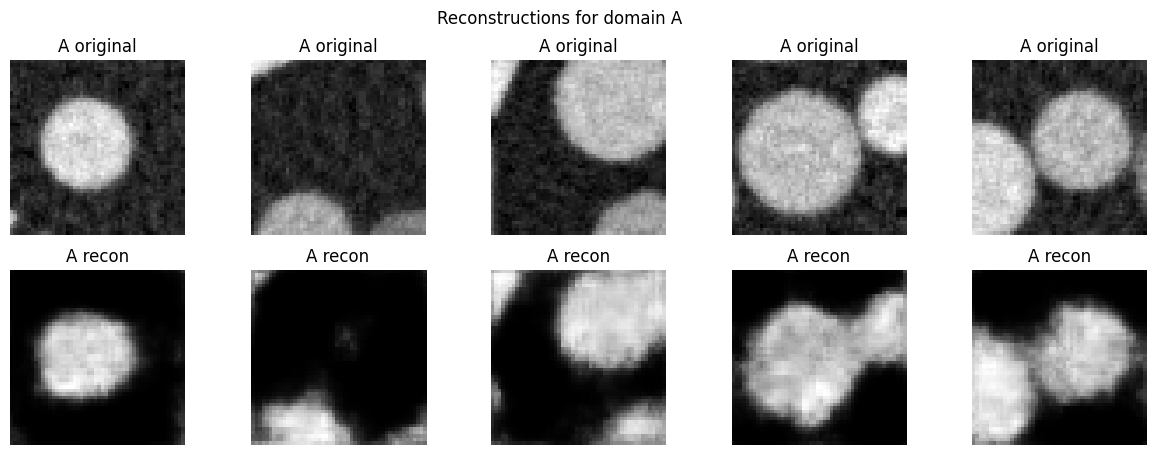

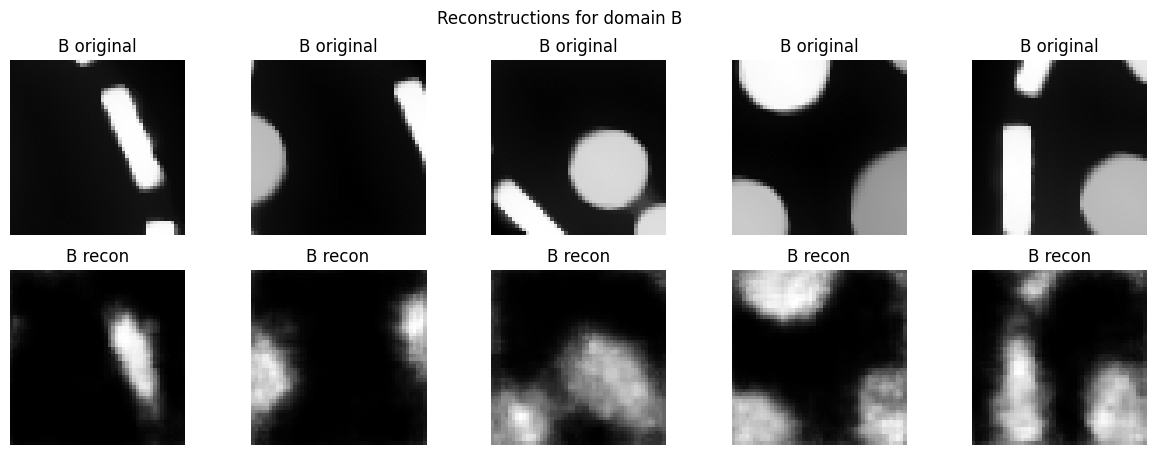

In [13]:

# ✅ Visualize some reconstructions from A and B
# Encode batch of A
X_A = torch.tensor(A[:, None, :, :], dtype=torch.float32).to(device)
labels_A = torch.zeros(len(A), device=device)

with torch.no_grad():
    mu_A, _ = model.encode(X_A, labels_A)
    z_A = mu_A.cpu().numpy()

# Encode batch of B
X_B = torch.tensor(B[:, None, :, :], dtype=torch.float32).to(device)
labels_B = torch.ones(len(B), device=device)

with torch.no_grad():
    mu_B, _ = model.encode(X_B, labels_B)
    z_B = mu_B.cpu().numpy()

N_vis = 5
X_vis_A = X_A[:N_vis]
X_vis_B = X_B[:N_vis]
labels_vis_A = torch.zeros(len(X_vis_A), device=device)
labels_vis_B = torch.ones(len(X_vis_B), device=device)

# Reconstructions
with torch.no_grad():
    recon_A, _, _, _ = model(X_vis_A, labels_vis_A)
    recon_B, _, _, _ = model(X_vis_B, labels_vis_B)


# Plot
fig, axes = plt.subplots(2, N_vis, figsize=(15, 5))

for i in range(N_vis):
    axes[0, i].imshow(X_vis_A[i,0].cpu().numpy(), cmap='gray')
    axes[0, i].set_title("A original")
    axes[0, i].axis('off')

    axes[1, i].imshow(recon_A[i,0].cpu().numpy(), cmap='gray')
    axes[1, i].set_title("A recon")
    axes[1, i].axis('off')

plt.suptitle("Reconstructions for domain A")
plt.show()

# Same for B
fig, axes = plt.subplots(2, N_vis, figsize=(15, 5))

for i in range(N_vis):
    axes[0, i].imshow(X_vis_B[i,0].cpu().numpy(), cmap='gray')
    axes[0, i].set_title("B original")
    axes[0, i].axis('off')

    axes[1, i].imshow(recon_B[i,0].cpu().numpy(), cmap='gray')
    axes[1, i].set_title("B recon")
    axes[1, i].axis('off')

plt.suptitle("Reconstructions for domain B")
plt.show()
